<a href="https://colab.research.google.com/github/BrunoPinos/Categoriser-automatiquement-des-questions/blob/add_API/p5_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [21]:
# data analysis and wrangling
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

# text
import re
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from IPython.display import display, HTML

# Save objects
import joblib

# Set working directory
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/P5')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import

**SQL**  
I get 50,000 posts for every 10,000,000, the posts retrieved have a score> 10 and are questions

for n in range(1, 7):  
SELECT Id, Body, Title, Tags  
FROM Posts  
WHERE  
(Score >= 10) AND  
(PostTypeId = 1) AND  
(AcceptedAnswerId > 0) AND  
(ViewCount > 50000) AND  
(FavoriteCount > 3) AND  
(Id < n * 10000000) AND  
(Id >= (n - 1) * 10000000)

**Read**

In [22]:
n_files = 6
list_files = [pd.read_csv('./Data/QueryResults (' + str(n+1) + ').csv',
                          index_col='Id') for n in range(n_files)]

df = pd.concat(list_files, axis=0)
df

,Body,Title,Tags
Id,,,
10000005,<blockquote>\n<p><strong>Possible Duplicate:</...,PHP Sort array by field?,<php><arrays><sorting>
10000083,<p>I want to make an eventHandler that passes ...,Javascript event handler with parameters,<javascript><events><event-handling><handler>
10000335,<p><strong>Short version of question:</strong>...,How to use debug version of libc,<linux><gdb><libc><ldd>
10003270,"<p>I have declared a struct, and I try to pass...",GCC: array type has incomplete element type,<c><arrays><gcc><struct>
10003562,<p>I have a view on a storyboard the has a but...,How to segue back to a UIViewController that's...,<objective-c><ios><storyboard><segue>
...,...,...,...
1213074,<p>I'm trying to drag data from the Winforms p...,"WinForms Interop, Drag & Drop from WinForms ->...",<wpf><winforms><interop><drag-and-drop>
1213127,<p>Is there a way for a Java program to detect...,Detect OS Sleep and Wake Up events in Java,<java><mysql><database-connection><sleep>
1213137,<p>I know I can change the UITableView propert...,Is there a way to remove the separator line fr...,<iphone><uitableview>


# Pretreatment

I create text with title + body.  
I follow transformations on 2 question.  

In [23]:
sample = np.random.choice(len(df), 2)

def random_display(docs, sample):
    for s in sample:
        print(docs.iloc[s], '\n'+'-'*20+'\n'*2)

In [24]:
texts = (df.Title + ' ' +df.Body)


random_display(texts, sample)

Scheduling Python Script to run every hour accurately <p>Before I ask, <strong>Cron Jobs and Task Scheduler</strong> will be my last options, this script will be used across Windows and Linux and I'd prefer to have a coded out method of doing this than leaving this to the end user to complete.</p>
<p>Is there a library for Python that I can use to schedule tasks? I will need to run a function once every hour, however, over time if I run a script once every hour and use .sleep, &quot;once every hour&quot; will run at a different part of the hour from the previous day due to the delay inherent to executing/running the script and/or function.</p>
<p>What is the <strong>best</strong> way to schedule a function to run at a specific time of day (more than once) <em>without</em> using a Cron Job or scheduling it with Task Scheduler?</p>
<p><em>Or if this is not possible, I would like your input as well.</em></p>
<h2><strong>AP Scheduler fit my needs exactly.</strong></h2>
<h3>Version &lt; 3.0

The first part of our job is to clean up the text

1.   Remove superfluous parts: code parts, HTML tags, punctuation... 
2.   Create tokens: i.e. separate their text for each document into a list of  words
3.   Remove stopwords: words considered too common to be interesting in our analysis
4.   Lemmatize: transform all the words into a basic form whatever the form in which it appears in the document (plural, conjugated verb, feminine form ...)

In [25]:
# Stemming function

ps = nltk.stem.SnowballStemmer('english')

def stemming(doc):
    return [ps.stem(word) for word in doc]

# Lemmatization function
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(doc, nlp, banned_postags=['PUNCT', 'DET', 'PRON', 'CONJ',
                                            'ADV', 'INTJ']):
    doc = nlp(doc)
    return [token.lemma_ for token in doc if token.pos_ not in banned_postags]
    

# Remove stopwords
stop_words = stopwords.words('english')

# stop_words.extend([])
def remove_stopwords(doc):
    return " ".join([word for word in doc if word not in stop_words])  

I try stemming

In [26]:
# stop_words.extend([]) for stem
def remove_stopwords_0(doc):
    return [word for word in doc if word not in stop_words]

                      
# All processing
texts_cleaned_stem = (texts
                      # delete code parts
                      .apply(lambda x: re.sub('<code>(.|\n)*?</code>', '', x))
                      # remove HTML tags
                      .apply(lambda x: re.sub('<[^<]+?>', '', x))
                      # token
                      .apply(lambda x: simple_preprocess(x, min_len=2,
                                                         deacc=False))
                      # remove stop word
                      .apply(remove_stopwords_0)
                      # stem
                      .apply(lambda x: stemming(x))
                     )

random_display(texts_cleaned_stem, sample)

['schedul', 'python', 'script', 'run', 'everi', 'hour', 'accur', 'ask', 'cron', 'job', 'task', 'schedul', 'last', 'option', 'script', 'use', 'across', 'window', 'linux', 'prefer', 'code', 'method', 'leav', 'end', 'user', 'complet', 'librari', 'python', 'use', 'schedul', 'task', 'need', 'run', 'function', 'everi', 'hour', 'howev', 'time', 'run', 'script', 'everi', 'hour', 'use', 'sleep', 'quot', 'everi', 'hour', 'quot', 'run', 'differ', 'part', 'hour', 'previous', 'day', 'due', 'delay', 'inher', 'execut', 'run', 'script', 'function', 'best', 'way', 'schedul', 'function', 'run', 'specif', 'time', 'day', 'without', 'use', 'cron', 'job', 'schedul', 'task', 'schedul', 'possibl', 'would', 'like', 'input', 'well', 'ap', 'schedul', 'fit', 'need', 'exact', 'version', 'lt', 'version', 'gt', 'animesh', 'pandey', 'answer'] 
--------------------


['read', 'excel', 'file', 'use', 'closedxml', 'excel', 'file', 'tabular', 'data', 'tri', 'read', 'excel', 'file', 'section', 'within', 'excel', 'file', '

Lemmatization

In [27]:
# All processing
texts_cleaned = (texts
                 # delete code parts
                 .apply(lambda x: re.sub('<code>(.|\n)*?</code>', '', x))
                 # remove HTML tags
                 .apply(lambda x: re.sub('<[^<]+?>', '', x))
                 # preprocess
                 .apply(lambda x: simple_preprocess(x, min_len=1, deacc=False))
                 # remove stop word
                 .apply(remove_stopwords)
                 # lemmatization
                 .apply(lambda x: lemmatization(x, nlp=nlp))
                )

random_display(texts_cleaned, sample)

['schedule', 'python', 'script', 'run', 'hour', 'ask', 'cron', 'jobs', 'task', 'scheduler', 'last', 'option', 'script', 'use', 'across', 'windows', 'linux', 'prefer', 'code', 'method', 'leave', 'end', 'user', 'complete', 'library', 'python', 'use', 'schedule', 'task', 'need', 'run', 'function', 'hour', 'time', 'run', 'script', 'hour', 'use', 'sleep', 'quot', 'hour', 'quot', 'run', 'different', 'part', 'hour', 'previous', 'day', 'due', 'delay', 'inherent', 'execute', 'running', 'script', 'function', 'good', 'way', 'schedule', 'function', 'run', 'specific', 'time', 'day', 'without', 'use', 'cron', 'job', 'scheduling', 'task', 'scheduler', 'possible', 'would', 'like', 'input', 'ap', 'scheduler', 'fit', 'need', 'version', 'lt', 'version', 'gt', 'animesh', 'pandey', 'answer'] 
--------------------


['read', 'excel', 'file', 'use', 'closedxml', 'excel', 'file', 'tabular', 'datum', 'try', 'read', 'excel', 'file', 'section', 'within', 'excel', 'file', 'tabular', 'need', 'loop', 'row', 'tabula

In our selected examples, we observe a much smaller number of remaining words, compared to the raw documents.

Now is the time to normalize our text, namely to put it in a format in which our model will be able to understand it. To do this, we will first create a dictionary which will assign a unique identifier to each word present in all the documents. We also display the number of words present in this dictionary

In [28]:
dictionary = Dictionary(texts_cleaned)
print("Taille du dictionnaire: ",len(dictionary))

Taille du dictionnaire:  63093


In order to make sure that these words can help us at least to find interesting patterns in our data at the time of modeling, we remove from the dictionary the words which do not appear in at least 50 different documents.

In [29]:
dictionary.filter_extremes(no_below=50)
print("Taille du dictionnaire: ", len(dictionary))

Taille du dictionnaire:  3627


With this filtering, we have removed more than 90% of the words in the dictionary, which could have been a source of noise once they became descriptors. Also, in order not to have too common words (like stopwords), let's take a look at the most common items

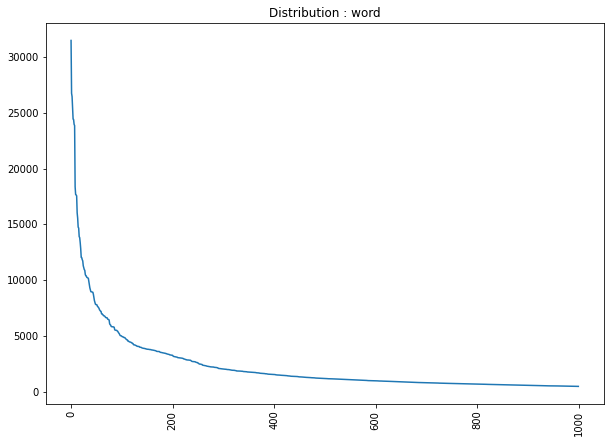

In [30]:
words_sorted = sorted(dictionary.dfs.items(), key=lambda x: x[1], reverse=True)
id2token = {value: key for key, value in dictionary.token2id.items()}

list_count = [count for e, (i, count) in enumerate(words_sorted[:1000])]
fig = plt.figure(1, figsize=(10, 7))
sn.lineplot(x = range(0, 1000), y = list_count)
plt.xticks(rotation=90)
plt.title('Distribution : word')
plt.show()

In [31]:
print("Mots les plus fréquents du dictionnaire:")
for e, (i, count) in enumerate(words_sorted[:100]):
    print(f"{e+1:2} {id2token[i]:15} {count:5}")

Mots les plus fréquents du dictionnaire:
 1 get             31491
 2 like            26756
 3 try             26455
 4 want            25482
 5 code            24441
 6 work            24401
 7 way             23972
 8 would           23858
 9 file            18376
10 find            17677
11 one             17638
12 know            17558
13 need            16040
14 follow          15565
15 error           14754
16 make            14672
17 example         13903
18 create          13809
19 run             13368
20 look            12821
21 problem         12042
22 c               12022
23 see             11837
24 seem            11728
25 set             11294
26 question        11102
27 add             10948
28 good            10885
29 value           10516
30 time            10393
31 method          10376
32 new             10251
33 could           10224
34 change          10203
35 thank           10171
36 application      9905
37 call             9596
38 function         9313
39 give  

We decide to delete the 70 most frequent words - 8 good words.


In [32]:
to_delete = [id2token[i] for e, (i, count) in enumerate(words_sorted[:70])]

list_remove = ['java', 'list', 'net', 'app', 'c', 'server',
               'class', 'application']

for word in list_remove:
  to_delete.remove(word) 

bad_ids = [dictionary.token2id[token] for token in to_delete]

dictionary.filter_tokens(bad_ids=bad_ids)

And finally, to conclude our pre-processing part, we create our bag of words. This representation makes it possible to count the number of occurrences of each word in the dictionary for each document. The resulting dataframe will serve as input data to our model

In [33]:
corpus = texts_cleaned.apply(dictionary.doc2bow)
random_display(corpus, sample)

[(40, 1), (54, 2), (73, 1), (77, 1), (118, 1), (127, 1), (138, 1), (175, 1), (230, 1), (235, 1), (271, 1), (314, 1), (381, 1), (503, 2), (541, 1), (551, 3), (555, 1), (567, 4), (611, 1), (691, 1), (695, 1), (731, 2), (750, 1), (759, 2), (800, 1), (1052, 1), (1194, 1), (1331, 5), (1368, 1), (1596, 1), (1665, 2), (1667, 3), (2120, 1), (2161, 3), (2295, 1), (2447, 1)] 
--------------------


[(27, 1), (72, 1), (206, 2), (329, 4), (451, 1), (509, 2), (654, 4), (1010, 1), (1070, 1), (1123, 1), (1573, 1)] 
--------------------




I save my objects

In [34]:
joblib.dump(corpus, 'corpus.sav')
joblib.dump(dictionary, 'dictionary.sav')
joblib.dump(df, 'df.sav')
joblib.dump(texts_cleaned, 'texts_cleaned.sav')

['texts_cleaned.sav']